<a href="https://colab.research.google.com/github/vigneswar96/vigneswar96/blob/main/Face_Mask_Prediction_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Task is to predict the mask around the face in a given image.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
HOME=os.getcwd()
print(HOME)

/content


In [8]:
import numpy as np
data = np.load('/content/drive/MyDrive/Datasets /Dataset- Images.npy', allow_pickle=True)

### Check a smaple from the dataset "images.npy"

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}],
  'imageWidth': 600,
  'imageHeight': 337}]

### Initialize Image height, image width with value 224

In [10]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

## Create Features and labels 
### 1) Here feature is the image 
### 2) The Label is the mask 
### 3) Images will be stored in "X"array
### 4) Masks will be stored in "masks" array

In [11]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing 

## 400 images in training 
## 9 images in testing data 

In [12]:
X_train = X[:400]
y_train = masks[:400]

In [13]:
X_test = X[400:]
y_test = masks[400:]

### Print a sample image, image array and its mask 

In [14]:
## Print the image and image array 

Image array: [[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.9

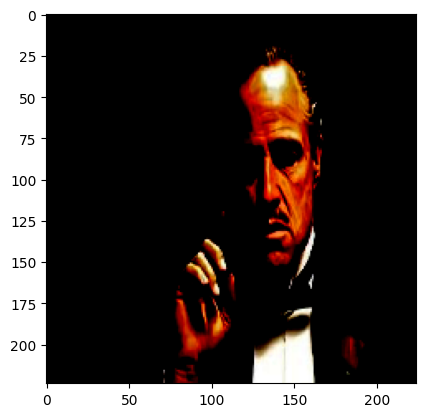

In [15]:
import matplotlib.pyplot as plt 

n=10
print("Image array:",X_train[n])
plt.imshow(X_train[n])

### Print the mask 

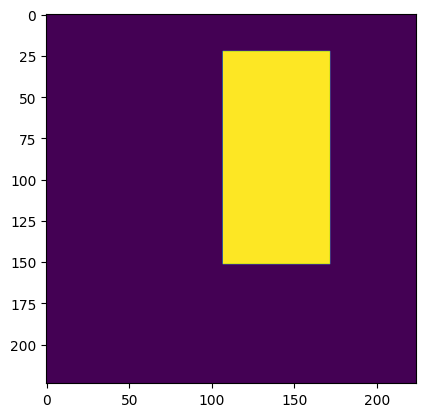

In [16]:
plt.imshow(masks[n])

### Ta 🥇 face detected 

### Create the model 

### 1) Add mobileNet as model with below parameter values 

### a) Input_shape:IMAGE_HEIGHT,IMAGE_WIDTH,3
### b) include_top:False
### c) alpha:1.0
### d) weights:"imagenet"

## 2) Add UNET architecture layers 
### a) THis is the trickiest part of the project, where we need to research and implement it correctly 

In [19]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function 
### Give trainable=False as argument, if you want to freeze lower layers for fast training(but low accuracy)

In [21]:
model = create_model()  

17225924/17225924 [==============================] - 2s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


### Print model Summary 

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

### Dfine dice coefficient fucntion 

### 1) Create a function to calculate dice coefficient

In [27]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
     numerator = 2*reduce_sum(y_true * y_pred)
     denominator = reduce_sum(y_true + y_pred)
     return numerator / (denominator + epsilon())

### Define Loss function 

In [30]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())


### Compile the model using the below parameters 
#### 1) Loss: Use the loss function defined above 
##### 2) Optimizers: Use adam optimizer
##### 3) Metrics : Use dice_coefficient function defined above 

In [31]:
model.compile(loss=loss, optimizer='adam', metrics= [dice_coefficient])

### Define callbacks 
#### Use Model Check point 
#### Use Earlystopping 
#### Use Reduce LROnPlateau

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor = "loss", patience= 5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model 
#### Epochs: Hmmm lets decide later ⏰
#### Batch_Size= 1
#### Callbacks: use the callbacks defined above 

In [33]:
model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint,reduce_lr, stop ])

Epoch 1/10
399/400 [============================>.] - ETA: 0s - loss: 1.2129 - dice_coefficient: 0.5108
Epoch 1: loss improved from inf to 1.21116, saving model to model-1.21.h5
400/400 [==============================] - 49s 44ms/step - loss: 1.2112 - dice_coefficient: 0.5113 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.8526 - dice_coefficient: 0.6034
Epoch 2: loss improved from 1.21116 to 0.85263, saving model to model-0.85.h5
400/400 [==============================] - 17s 42ms/step - loss: 0.8526 - dice_coefficient: 0.6034 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.7067 - dice_coefficient: 0.6557
Epoch 3: loss improved from 0.85263 to 0.70671, saving model to model-0.71.h5
400/400 [==============================] - 17s 42ms/step - loss: 0.7067 - dice_coefficient: 0.6557 - lr: 0.0010
Epoch 4/10
399/400 [============================>.] - ETA: 0s - loss: 0.6667 - dice_coefficient: 0.6717
Epoch 4: loss impr

## Get the predicted mask for a test image 


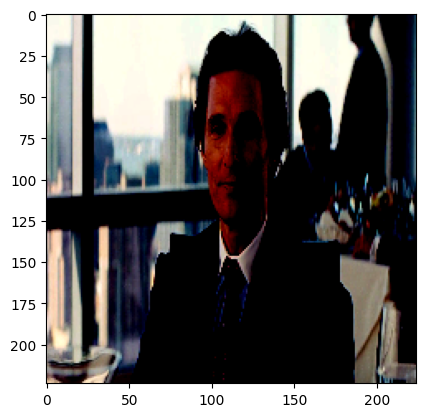

In [36]:
plt.imshow(X_test[3])

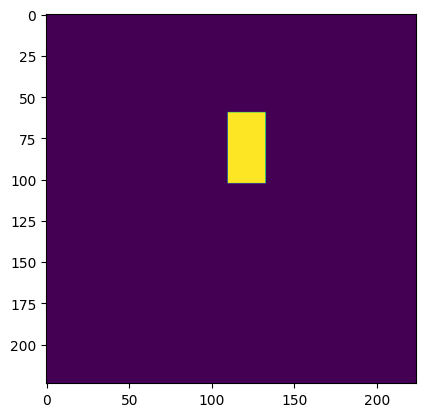

In [37]:
plt.imshow(masks[3])

### Fine I know what you are looking for 

### Where is the results? 

### Predict the mask on the test image 

In [41]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[m]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 

1/1 [==============================] - 1s 1s/step


Fine... blah Impose the mask on the test image 

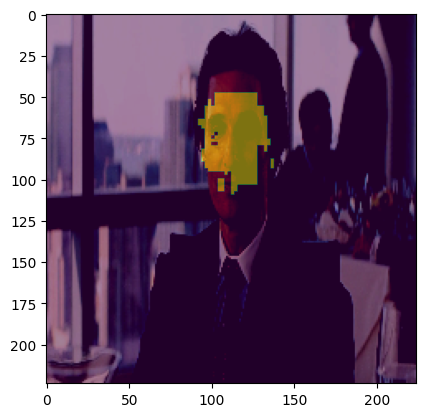

In [42]:
plt.imshow(X_test[3])
plt.imshow(pred_mask, alpha=0.5)

*****************************************END of this story**************** ****